In [149]:
import requests
import bs4
import re
import pandas as pd
import json
import numpy as np
from bs4 import BeautifulSoup
file_path = 'data/'

# JSON 파일 불러오기
with open(file_path + 'PREFIX.json', 'r', encoding='utf-8') as f:
    PREFIX = json.load(f)
with open(file_path + 'SUFFIX.json', 'r', encoding='utf-8') as f:
    SUFFIX = json.load(f)


In [150]:

# 기존 구조: nested 딕셔너리 만들기
req_parameter_nested = {
    region: {
        district: PREFIX[region] + suffix[-3:]
        for district, suffix in districts.items()
    }
    for region, districts in SUFFIX.items()
}

# 평탄화(flatten) + 시단위 전체 지역 코드 추가
req_parameter = {}

for region, districts in req_parameter_nested.items():
    # 시 전체 ('서울') 코드: '강남구'처럼 직접 접근할 수 있도록
    if '전체' in districts:
        req_parameter[region] = districts['전체']  # ex) '서울': '101000'
    # 각 구/군도 추가
    for district, code in districts.items():
        req_parameter[district] = code

req_parameter2={
    '지역별':'domestic',
    '직업별':'job-category',
    '역세권별':'subway',
    'HOT100':'hot100',
    '헤드헌팅':'headhunting'
}


In [ ]:
def parse_location_input(user_input):

    # 3. 지역명을 코드로 변환
    region_codes = []
    for region in user_input:
        code = req_parameter.get(region)
        if code:
            region_codes.append(code)
        else:
            print(f"경고: '{region}' 지역을 찾을 수 없습니다.")

    return "%2C".join(region_codes)  # URL 인코딩된 콤마

loc_cd_param = parse_location_input(['서울', '부산'])

In [177]:
job_link_list = []
corp_link_list = []
logo_list = []
title_list =[]
job_list = []
corp_list = []
local_list = []
exp_list = []
grad_list = []
date_list = []
badge_list = []
upload_list = []
for page in range(1,50):
    url = "https://www.saramin.co.kr/zf_user/jobs/list/{지역별}?page={page}&loc_cd={loc_cd_param}&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y".format(page=page, **req_parameter2, loc_cd_param=loc_cd_param)
    print(url)
    req_header = {
        'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/135.0.0.0 Safari/537.36'
    }

    res = requests.get(url, headers = req_header)
    res.encoding = 'utf-8'

    
    if res.ok:
        html = res.text
        soup = BeautifulSoup(html, 'html.parser') 
        # CSS 선택자
        a_tag_list = soup.select("div#default_list_wrap div.list_body div.box_item")
        # <a> 태그 리스트 순회하기    
        for a_tag in a_tag_list:
            # 링크
            job_link_dict = {}
            if a_tag.find("div", class_ ="job_tit").find("a", class_ = "str_tit") == None:
                print(a_tag.find("div", class_ ="job_tit"))
                job_link_dict['링크'] = 'NULL'
            else:
                job_link_dict['링크'] = "https://www.saramin.co.kr" + a_tag.find("div", class_ ="job_tit").find("a", class_ = "str_tit")['href']
            job_link_list.append(job_link_dict)

            # 회사 링크
            corp_link_dict = {}
            if a_tag.find("div", class_ ="col company_nm").find("a", class_ = "str_tit") == None:
                corp_link_dict['회사링크'] = 'NULL'
            else:
                corp_link_dict['회사링크'] = "https://www.saramin.co.kr" + a_tag.find("div", class_ ="col company_nm").find("a", class_ = "str_tit")['href']
            corp_link_list.append(corp_link_dict)

            # 로고
            # logo_dict = {}
            # if len(a_tag.select("span.logo img[src*='banner_logo/company/logo_banner/']")) == 0:
            #     logo_dict['로고'] = 'Null'
            # else:
            #     img_url = a_tag.select("span.logo img[src*='banner_logo/company/logo_banner/']")
            #     logo_dict['로고'] = img_url[0]['src']
            # logo_list.append(logo_dict)

            # 제목
            title_dict = {}
            if len(a_tag.find("div", class_ ="col notification_info").find("div", class_ = "job_tit").select("span")) == 0:
                title_dict['제목'] = 'Null'
            else:
                title = a_tag.find("div", class_ ="col notification_info").find("div", class_ = "job_tit").select("span")[0].text
                title_dict['제목'] = title
            title_list.append(title_dict)

            # 회사
            corp_dict = {}
            if len(a_tag.find("div", class_ ="col company_nm").find(class_ = "str_tit")) == 0:
                corp_dict['회사'] = 'Null'
            else:
                corp = a_tag.find("div", class_ ="col company_nm").find(class_ = "str_tit").text
                corp_dict['회사'] = corp
            corp_list.append(corp_dict)
            clean_corp = []
            for item in corp_list:
                clean_item = {key: re.sub(r'\s+', ' ', value).strip() for key, value in item.items()}
                clean_corp.append(clean_item)
            
            # 직무
            job_dict = {}
            job = a_tag.select_one('.job_sector')
            if len(job) == 0:
                job_dict['직무'] = 'Null'
            else:
                jobs = [span.get_text(strip=True).replace('::before', '').strip() for span in job.find_all('span')]
                job_dict['직무'] = jobs
            job_list.append(job_dict)
            
            # 지역, 경력, 학력
            temp = a_tag.find("div", class_ = "col recruit_info")
            local_dict = {}
            exp_dict = {}
            grad_dict = {}
            if len(temp) >= 3:
                local_dict['지역'] = temp.find("p", class_ = "work_place").text
                exp_dict['요구경력'] = temp.find("p", class_ = "career").text
                grad_dict['최소학력'] = temp.find("p", class_ = "education").text
            else:
                local_dict['지역'] = 'NULL'
                exp_dict['요구경력'] = 'NULL'
                grad_dict['최소학력'] = 'NULL'
            local_list.append(local_dict)
            exp_list.append(exp_dict)
            grad_list.append(grad_dict)

            for region in local_list:
                if region['지역'].endswith(' 외'):
                    region['지역'] = region['지역'][:-2]

            # 기간
            date_dict = {}
            if len(a_tag.select("span.date")) == 0:
                date_dict['기간'] = 'Null'
            else:
                date = a_tag.select("span.date")[0].text
                date_dict['기간'] = date
            date_list.append(date_dict)

            clean_date = []
            for item in date_list:
                clean_item = {key: re.sub(r'\s+', ' ', value).strip() for key, value in item.items()}
                clean_date.append(clean_item)

            # 등록일자
            upload_dict = {}
            if len(a_tag.select_one("span.deadlines")) == 0:
                upload_dict['등록일자'] = 'Null'
            else:
                upload = a_tag.select("span.deadlines")[0].text
                upload_dict['등록일자'] = upload
            upload_list.append(upload_dict)

            # 배지
            badge_dict = {}
            if a_tag.select_one(".job_badge") == None:
                badge_dict['배지'] = 'Null'
            else:
                badge = a_tag.select_one(".job_badge").find("span").text
                badge_dict['배지'] = badge
            badge_list.append(badge_dict)
            clean_badge = []
            for item in badge_list:
                clean_item = {key: re.sub(r'\s+', ' ', value).strip() for key, value in item.items()}
                clean_badge.append(clean_item)

    else:
        # 응답(response)이 Error 이면 status code 출력    
        print(f'에러 코드 1= {res.status_code}')


https://www.saramin.co.kr/zf_user/jobs/list/domestic?page=1&loc_cd=101000%2C106000&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y
https://www.saramin.co.kr/zf_user/jobs/list/domestic?page=2&loc_cd=101000%2C106000&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y
https://www.saramin.co.kr/zf_user/jobs/list/domestic?page=3&loc_cd=101000%2C106000&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y
https://www.saramin.co.kr/zf_user/jobs/list/domestic?page=4&loc_cd=101000%2C106000&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y
https://www.saramin.co.kr/zf_user/jobs/list/domestic?page=5&loc_cd=101000%2C106000&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y
https://www.saramin.co.kr/zf_user/jobs/list/domestic?page=6&loc_cd=101000%2C106000&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y
https://www.saramin.co.kr/zf_user/jobs/list/domestic?page=7&loc_

In [178]:

combined_list = []
for link, corp_link, title, corp, job, local, exp, grad, date, upload, badge in zip(job_link_list, corp_link_list,title_list, clean_corp, job_list, local_list, exp_list, grad_list, clean_date, upload_list, clean_badge):
    merged_dict = {}
    merged_dict.update(link)
    merged_dict.update(corp_link)
    merged_dict.update(title)
    merged_dict.update(corp)
    merged_dict.update(job)
    merged_dict.update(local)
    merged_dict.update(exp)
    merged_dict.update(grad)
    merged_dict.update(date)
    merged_dict.update(upload)
    merged_dict.update(badge)
    combined_list.append(merged_dict)



In [179]:

# DataFrame으로 변환
df = pd.DataFrame(combined_list)
print(job_link_list)
df.head()

[{'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50339055'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50338910'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50521122&adsCategoryItem=effect_bold&'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50532697'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50498496'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50510123'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50518176'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50519379'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50512210'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50032470&adsCategoryItem=effect_bold&'}, {'링크': 'htt

,링크,회사링크,제목,회사,직무,지역,요구경력,최소학력,기간,등록일자,배지
0,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,[영업-없습니다][안정적-급여]신용카드-콜센터 단순-인바운드 팀,좋은일자리센터,"[총무, 사무보조, 사무행정, 전화응대, 영업지원]",서울 성동구,신입 · 경력 · 정규직 외,학력무관,채용시,1분 전 수정,워라밸
1,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,[근무만족도높은(장기근속센터)]정보변경등 단순-문의응대 상담,좋은일자리센터,"[안내데스크, 총무, 사무보조, 사무행정, 전화응대]",서울 성동구,신입 · 경력 · 정규직 외,학력무관,채용시,1분 전 수정,워라밸
2,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,"[MICE]국제회의,컨벤션 기획(PCO)/전시기획/UX,UI 디자이너 채용",(주)메쎄이상,"[거래처관리, 거래처영업, 고객관리, 공공영업, 기업영업]",서울 마포구,경력무관 · 정규직,학력무관,~04.30(수),2분 전 수정,인기있는
3,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,Backend Engineer (5년이상),(주)그릿스탠다드,"[백엔드/서버개발, 웹개발, 프론트엔드, DBA, SE(시스템엔지니어)]",서울전체,5 ~ 15년 · 정규직,고졸↑,~05.16(금),2분 전 등록,취업축하금
4,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,해운대 자명병원 야간전담 조무사 채용,해운대자명병원,[간호조무사],부산 해운대구,신입 · 경력 · 정규직,학력무관,~05.14(수),3일 전 등록,인기있는


In [180]:
# '원문' 열 만들기 (기존 요구경력 복사)
df['원문'] = df['요구경력']

def split_info(text):
    if not isinstance(text, str):
        return pd.Series([None, None])
    
    parts = re.split(r'\s*·\s*', text)

    if len(parts) >= 2:
        exp = ' · '.join(parts[:-1]).strip()
        job_type = re.sub(r'\s*외$', '', parts[-1].strip())
        return pd.Series([exp, job_type])
    else:
        return pd.Series([text.strip(), None])
    
# 위에서 고친 split_info 함수 적용
df[['요구경력_raw', '계약종류']] = df['원문'].apply(split_info)

# 문자열 확인 추가된 normalize 함수
def normalize_experience(exp):
    if not isinstance(exp, str):
        return None  # 또는 '기타', '불명' 등

    exp = exp.strip()
    if '신입' in exp and '경력' in exp:
        return '신입/경력'
    elif '신입' in exp:
        return '신입'
    elif '경력무관' in exp or '년수무관' in exp:
        return '경력무관'
    elif re.match(r'경력 \d+년↑', exp):
        years = re.findall(r'\d+', exp)[0]
        return f'{years}년 이상'
    elif re.match(r'경력 \d+년↓', exp):
        years = re.findall(r'\d+', exp)[0]
        return f'{years}년 이하'
    elif re.match(r'\d+ ~ \d+년', exp):
        return exp.replace(' ', '')
    elif exp == '경력':
        return '경력'
    else:
        return exp

# 적용
df['요구경력'] = df['요구경력_raw'].apply(normalize_experience)
df.drop(columns=['요구경력_raw'], inplace=True)
df['계약종류'].unique()

array(['정규직', '계약직', '인턴직', '프리랜서', '아르바이트', '위촉직', '전임', '파견직', '교육생',
       '파트', None, '경력'], dtype=object)

In [181]:
df['등록일자'].unique()

array(['1분 전 수정', '2분 전 수정', '2분 전 등록', '3일 전 등록', '2일 전 등록', '3분 전 수정',
       '1일 전 등록', '7분 전 수정', '58일 전 등록', '4시간 전 수정', '52일 전 등록',
       '36일 전 등록', '28일 전 등록', '24일 전 등록', '9일 전 등록', '8일 전 등록',
       '7일 전 등록', '5일 전 등록', '6일 전 등록', '22시간 전 수정', '5시간 전 수정',
       '4시간 전 등록', '13일 전 등록', '19시간 전 등록', '15일 전 등록', '10분 전 수정',
       '12분 전 수정', '22시간 전 등록', '13분 전 수정', '14분 전 수정', '15분 전 수정',
       '16분 전 수정', '16분 전 등록', '5시간 전 등록', '17분 전 수정', '17분 전 등록',
       '23시간 전 등록', '55일 전 등록', '16일 전 등록', '12일 전 등록', '10일 전 등록',
       '20시간 전 등록', '41일 전 등록', '21시간 전 수정', '35일 전 등록', '18분 전 등록',
       '21시간 전 등록', '18시간 전 등록', '1시간 전 수정', '62일 전 등록', '18분 전 수정',
       '23시간 전 수정', '2시간 전 등록', '19분 전 수정', '19분 전 등록', '22분 전 등록',
       '23분 전 등록', '23분 전 수정', '24분 전 수정', '25분 전 수정', '25분 전 등록',
       '26분 전 수정', '26분 전 등록', '27분 전 등록', '28분 전 등록', '27분 전 수정',
       '28분 전 수정', '40일 전 등록', '3시간 전 수정', '27일 전 등록', '22일 전 등록',
       '31일 전 등록', '29분 전 수정', '29분 전 등록', '32분 전 등록',

In [182]:
import re

def process_registration_date(text):
    if not isinstance(text, str):
        return None
    
    # '수정'과 '등록' 제거
    text = re.sub(r'\s*(수정|등록)\s*', '', text)
    
    # 'n시간 전'을 '당일'로 변경
    text = re.sub(r'\d+\s*시간\s*전', '당일', text)
    
    # 'n분 전'은 그대로 두기
    text = re.sub(r'\d+\s*분\s*전', '당일', text)
    
    return text.strip()

# 적용
df['등록일자'] = df['등록일자'].apply(process_registration_date)

In [183]:
df['등록일자'].unique()

array(['당일', '3일 전', '2일 전', '1일 전', '58일 전', '52일 전', '36일 전', '28일 전',
       '24일 전', '9일 전', '8일 전', '7일 전', '5일 전', '6일 전', '13일 전', '15일 전',
       '55일 전', '16일 전', '12일 전', '10일 전', '41일 전', '35일 전', '62일 전',
       '40일 전', '27일 전', '22일 전', '31일 전', '29일 전', '53일 전', '34일 전',
       '30일 전', '43일 전', '23일 전', '17일 전', '20일 전', '544일 전', '59일 전',
       '66일 전', '63일 전', '51일 전', '50일 전', '44일 전', '37일 전', '4일 전',
       '19일 전', '21일 전', '14일 전', '537일 전', '38일 전', '48일 전', '57일 전',
       '104일 전', '150일 전', '125일 전', '294일 전', '107일 전', '42일 전', '26일 전',
       '49일 전', '229일 전', '254일 전'], dtype=object)

In [184]:
df['기간'].unique()

array(['채용시', '~04.30(수)', '~05.16(금)', '~05.14(수)', '상시채용', '~04.28(월)',
       '~04.25(금)', 'D-2', '~05.11(일)', '~05.06(화)', '~04.29(화)',
       '~05.01(목)', '~04.27(일)', '~05.12(월)', '~06.13(금)', 'D-6', 'D-7',
       '18시 마감', '~05.15(목)', 'D-4', '~06.16(월)', '~05.13(화)',
       '~06.08(일)', '~05.17(토)', '내일마감', '~05.08(목)', 'D-5', '~05.04(일)',
       '~06.06(금)', '~05.10(토)', '~06.04(수)', '~05.09(금)', 'D-3',
       '~05.05(월)', '~06.10(화)', '~06.15(일)', '~05.03(토)', '~06.07(토)',
       '~05.20(화)', '오늘마감', '~05.07(수)', '~05.27(화)', '~04.26(토)',
       '~05.30(금)', '~05.02(금)', '~06.14(토)', '~06.09(월)', '~05.18(일)',
       '~05.28(수)', '~05.31(토)', '~05.29(목)', '~07.12(토)', '~05.23(금)',
       '~05.19(월)', '~05.24(토)', '~06.02(월)', '~07.06(일)', '15시 마감',
       '~06.11(수)', '~06.25(수)', '~07.14(월)', '~06.27(금)', '~07.13(일)',
       '~06.01(일)', '~06.26(목)', '~05.25(일)', '~06.03(화)', '~05.26(월)'],
      dtype=object)

In [159]:
df.head()

,링크,회사링크,제목,회사,직무,지역,요구경력,최소학력,기간,등록일자,배지,원문,계약종류
0,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,㈜참프레 2025년 신입/경력 공개채용 (2차),(주)참프레,"[손익관리, 원가관리, 원가회계, 법무사, 사무직]",전국,신입/경력,학력무관,D-2,14일 전,생산 스크랩 TOP100,신입 · 경력 · 정규직,정규직
1,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,2025년 신한은행 리더십 특별채용,(주)신한은행,"[외환관리, 출납, 사무직, 문서작성, 사무보조]",전국,신입/경력,학력무관,~04.29(화),3일 전,고객상담·TM 지원 TOP100,신입 · 경력 · 정규직,정규직
2,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,"남해종합건설㈜ 토목(도로/태양광발전소 시설/수중공사),건축,안전 경력사원 채용",남해종합건설(주),"[건축가, 공무, 내선전공, 보건관리자, 비파괴검사원]",전국,경력,"대학(2,3년)↑",~04.25(금),당일,평균연봉 상위 10%,경력 · 정규직,정규직
3,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,태인종합건설㈜ 각 부문 경력사원 채용,태인종합건설(주),"[경리, 경리사무원, 전산회계, 급여(Payroll), 기업회계]",전국,경력,학력무관,~05.14(수),당일,인사·노무·HRD 조회 TOP100,경력 · 정규직,정규직
4,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,2025년 신입 공개채용(기술),한국전기안전공사,"[기전기사, 전기기사, 전기설계, 건축전기, 전기설비]",전국,신입,학력무관,D-6,7일 전,건설·건축 스크랩 급상승,신입 · 정규직,정규직


In [185]:
df.replace("NULL", np.nan, inplace=True)
for i in df.columns :
    missingValueRate = df[i].isna().sum() / len(df) * 100
    if missingValueRate > 0 :
        print("{} 결측치 비율: {}%".format(i,round(missingValueRate, 2)))

회사링크 결측치 비율: 6.9%
계약종류 결측치 비율: 0.2%


In [186]:
df.shape

(2450, 13)

In [187]:

df.dropna(axis = 0, inplace=True)
df.shape

(2276, 13)

In [188]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

font_path = 'C:\\windows\\Fonts\\malgun.ttf'
font_prop = fm.FontProperties(fname=font_path).get_name()


matplotlib.rc('font', family=font_prop)

In [189]:
dev_df = df[df['제목'].str.contains('개발', na=False)]

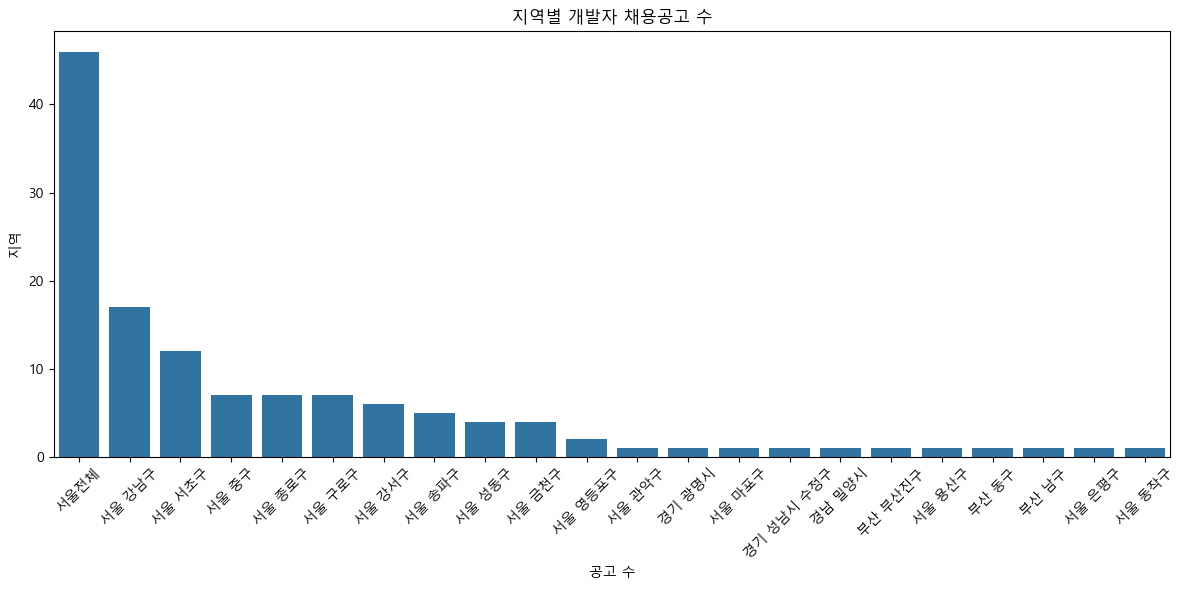

In [190]:

# 지역별 공고 수
plt.figure(figsize=(12, 6))
sns.countplot(data=dev_df, x='지역', order=dev_df['지역'].value_counts().index)
plt.title('지역별 개발자 채용공고 수')
plt.xlabel('공고 수')
plt.ylabel('지역')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

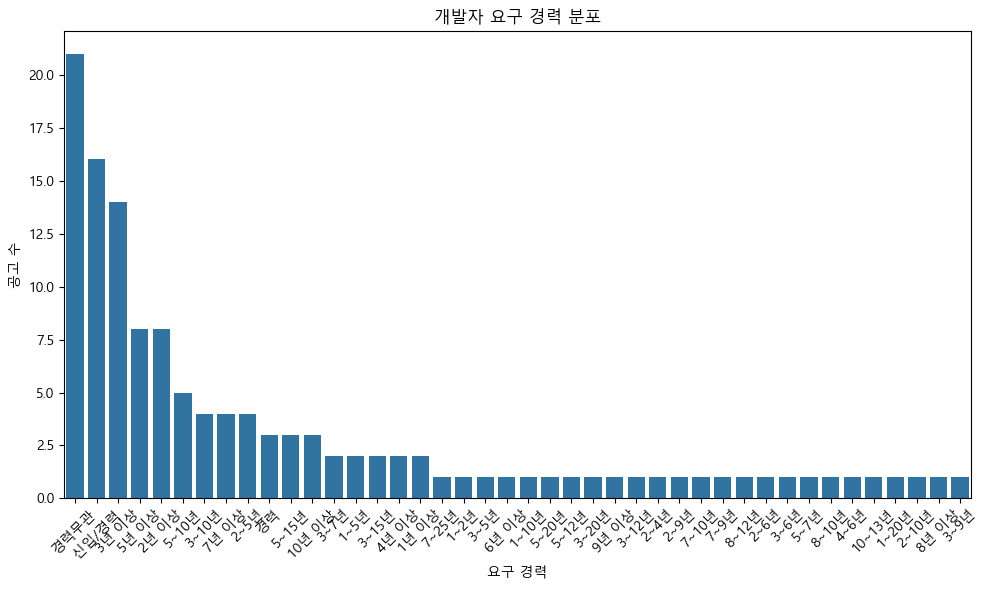

In [191]:
plt.figure(figsize=(10, 6))
sns.countplot(data=dev_df, x='요구경력', order=dev_df['요구경력'].value_counts().index)
plt.title('개발자 요구 경력 분포')
plt.xlabel('요구 경력')
plt.ylabel('공고 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

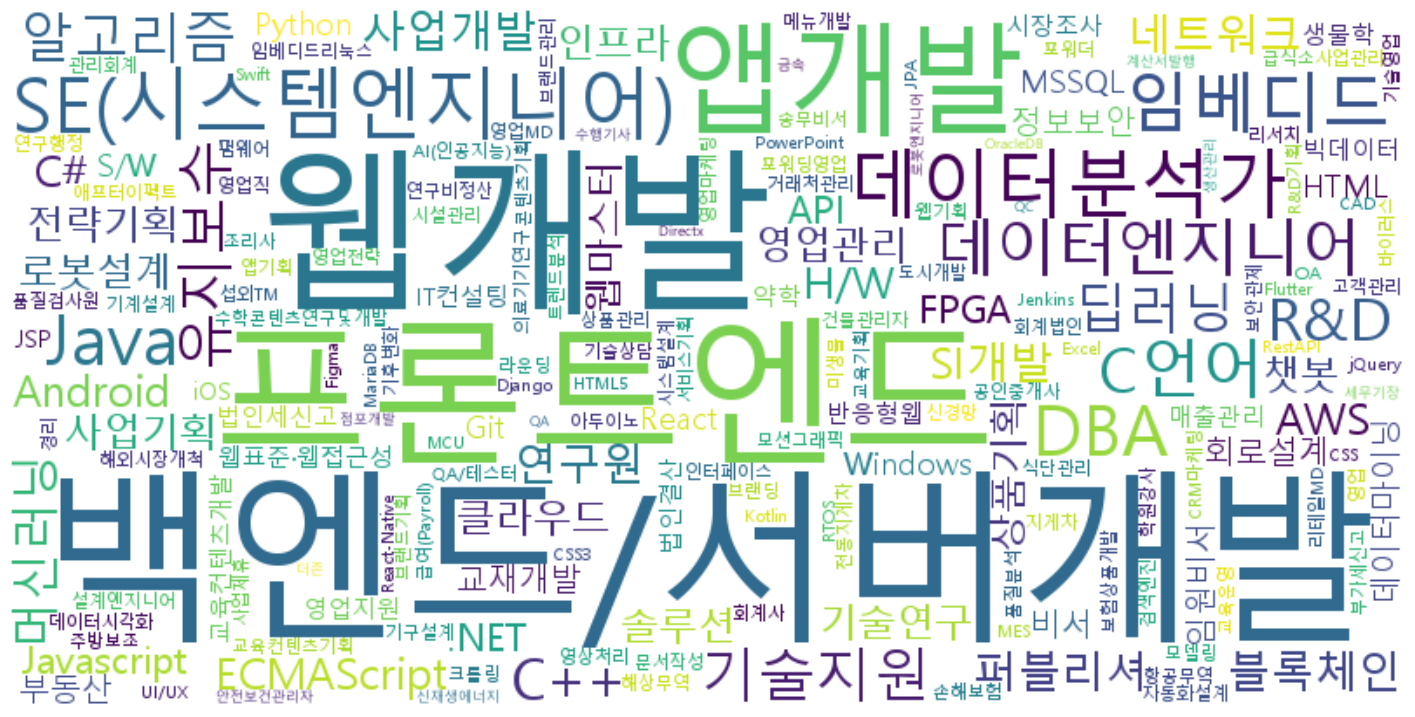

In [192]:
from wordcloud import WordCloud
df_exploded = dev_df.explode('직무')
job_counts = df_exploded['직무'].value_counts()

wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white', colormap='viridis')
wordcloud.generate_from_frequencies(job_counts.to_dict())

plt.figure(figsize=(18, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

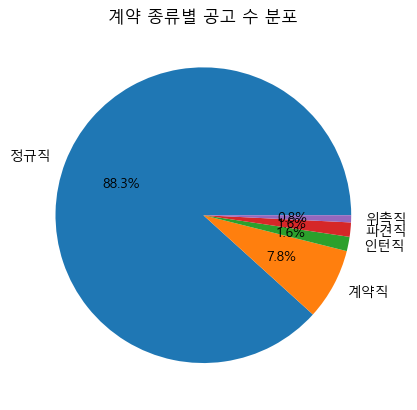

In [193]:
contract_counts = dev_df['계약종류'].value_counts()

contract_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('계약 종류별 공고 수 분포')
plt.ylabel('')
plt.show()

array(['전국'], dtype=object)

C:\Users\user\AppData\Local\Temp\ipykernel_15948\1838986363.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['광역시도'] = filtered_df['지역'].apply(convert_region)


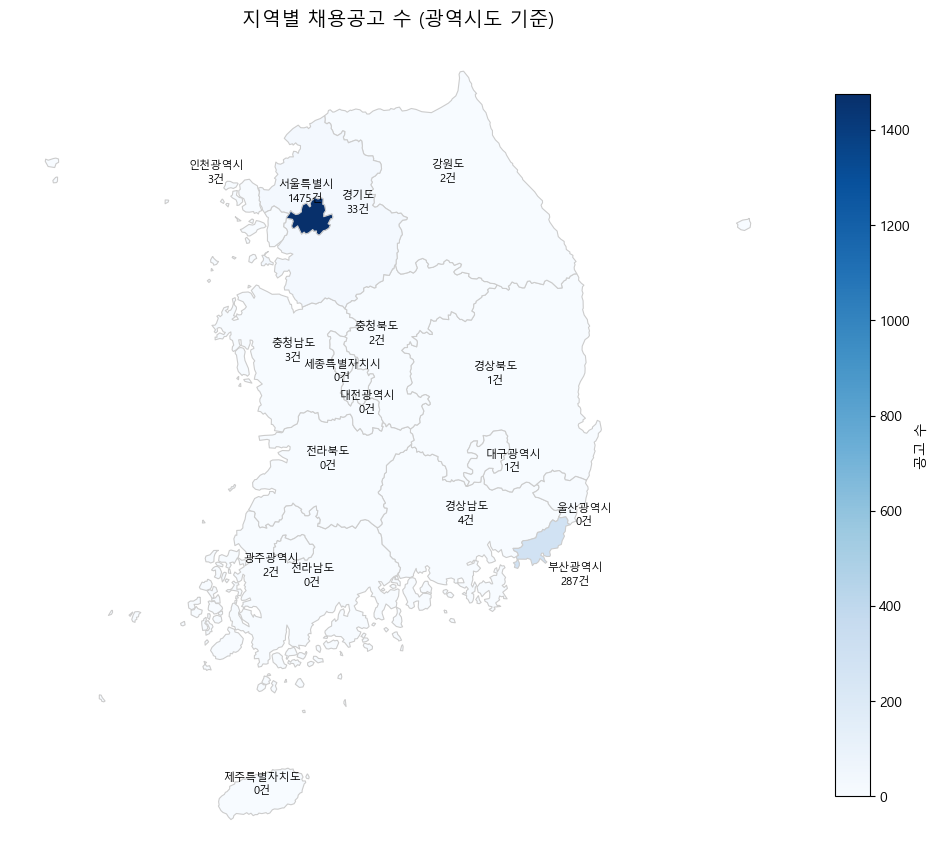

In [194]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 1. 지역명을 광역시/도로 변환하는 함수
def convert_region(name):
    if name == '전국':
        return None
    parts = name.split()
    region_map = {
        '서울': '서울특별시', '부산': '부산광역시', '대구': '대구광역시',
        '인천': '인천광역시', '광주': '광주광역시', '대전': '대전광역시',
        '울산': '울산광역시', '세종': '세종특별자치시', '경기': '경기도',
        '강원': '강원도', '충북': '충청북도', '충남': '충청남도',
        '전북': '전라북도', '전남': '전라남도', '경북': '경상북도',
        '경남': '경상남도', '제주': '제주특별자치도'
    }
    return region_map.get(parts[0], None)

# 2. 필터된 데이터프레임에 광역시도 열 추가
filtered_df = df[df['지역'] != '서울전체'] 
filtered_df['광역시도'] = filtered_df['지역'].apply(convert_region)

# 3. 지역별 공고 수 집계
region_counts = filtered_df['광역시도'].value_counts().reset_index()
region_counts.columns = ['지역', '공고수']

# 4. GeoJSON 파일 불러오기
gdf = gpd.read_file('data/skorea_provinces_geo_simple.json')

# 5. 병합 (left join으로 모든 지역 유지)
merged = gdf.merge(region_counts, left_on='name', right_on='지역', how='left')
merged['공고수'] = merged['공고수'].fillna(0).astype(int)

# 6. 일부 지역의 라벨이 겹치지 않도록 위치 보정값 정의
label_offsets = {
    '서울특별시': (0, 0.1),
    '세종특별자치시': (0, -0.2),
    '인천광역시': (-0.3, 0.1),
    '대전광역시': (0.1, -0.2),
    '광주광역시': (-0.2, -0.2),
    '대구광역시': (0.2, -0.1),
    '부산광역시': (0.3, -0.3),
    '울산광역시': (0.2, -0.2),
}

# 7. 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
merged.plot(
    column='공고수',
    cmap='Blues',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'shrink': 0.6, 'label': '공고 수'}
)

# 8. 지도 위에 텍스트 표시 (지역명 + 공고수)
for idx, row in merged.iterrows():
    point = row.geometry.representative_point()
    dx, dy = label_offsets.get(row['name'], (0, 0))
    plt.annotate(
        text=f"{row['name']}\n{row['공고수']}건",
        xy=(point.x + dx, point.y + dy),
        ha='center',
        fontsize=8,
        color='black'
    )

plt.title('지역별 채용공고 수 (광역시도 기준)', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()
